# Read in the data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
import numpy as np
import re

In [2]:
data_files = [
'https://dsserver-prod-resources-1.s3.amazonaws.com/323/ap_2010.csv',
'https://dsserver-prod-resources-1.s3.amazonaws.com/323/demographics.csv',
'https://dsserver-prod-resources-1.s3.amazonaws.com/323/hs_directory.csv',
'https://dsserver-prod-resources-1.s3.amazonaws.com/323/class_size.csv',
'https://dsserver-prod-resources-1.s3.amazonaws.com/323/graduation.csv',
'https://dsserver-prod-resources-1.s3.amazonaws.com/323/sat_results.csv'
]

data = {}

for f in data_files:
    df = pd.read_csv(f)
    nm = f.replace("https://dsserver-prod-resources-1.s3.amazonaws.com/323/", "").replace(".csv", "")
    data[nm] = df

# Read in the surveys

In [3]:
file1 = 'https://raw.githubusercontent.com/sams248/DataQuest/master/Missions/2.%20Data%20Analysis%20and%20Visualisation/4.%20Data%20Cleaning/1.%20Data%20Cleaning%20Walkthrough/survey_d75.txt'
file2 = 'https://raw.githubusercontent.com/sams248/DataQuest/master/Missions/2.%20Data%20Analysis%20and%20Visualisation/4.%20Data%20Cleaning/1.%20Data%20Cleaning%20Walkthrough/survey_all.txt'


all_survey = pd.read_csv(file1, delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv(file2, delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE"] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == 2006]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Cohort                                       NaN
CSD                                     0.042948
AVERAGE CLASS SIZE                      0.381014
SIZE OF LARGEST CLASS                   0.314434
SIZE OF SMALLEST CLASS                  0.249949
schoolyear                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_percent                            -0.398750
sped_percent                           -0.448170
grade1                                  0.040663
grade2                                  0.040663
grade3                                  0.040663
grade4              

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

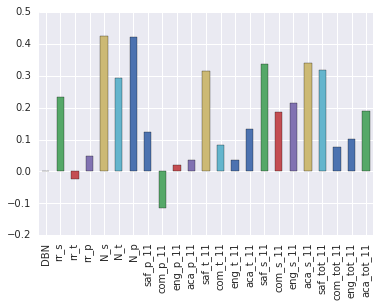

In [12]:
correlations[data["survey"].columns].plot.bar()

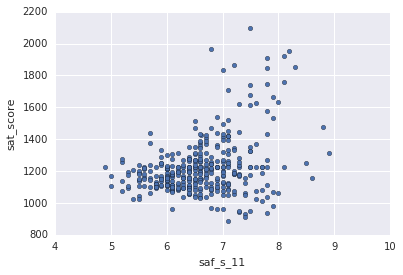

In [13]:
combined.plot.scatter('saf_s_11','sat_score')

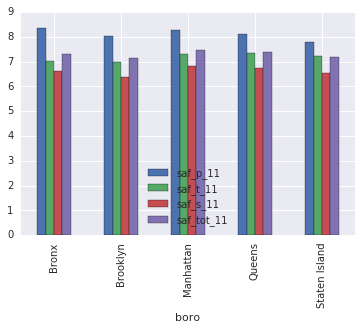

In [14]:
cols = [i for i in combined if 'saf_' in i]

combined.groupby('boro').mean()[cols].plot.bar()

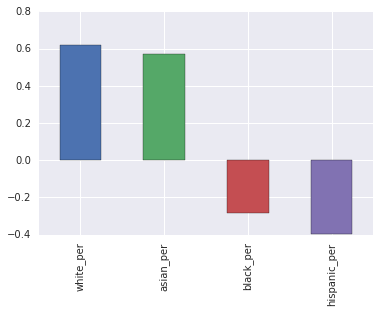

In [15]:
# Investigate racial differences in SAT scores - Are there any racial differences in sat scores??

cols = [
'white_per',
'asian_per',
'black_per',
'hispanic_per',
]

correlations[cols].plot(kind='bar')

This represents general bias againest Blacks and hispians!

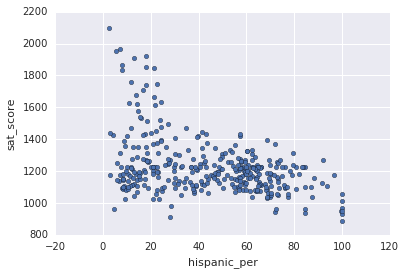

In [16]:
# Explore schools with low SAT scores and high values for hispanic_per.

combined.plot.scatter('hispanic_per', 'sat_score')

This shows general inverse proportion, between the percent of maxicans and sat scores! :(

In [17]:
# Research any schools with a hispanic_per greater than 95%.

combined[combined['hispanic_per']>95]

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,primary_address_line_1,city,state_code,zip,Location 1,start_time,end_time,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,525 West 50Th Street,New York,NY,10019,"525 West 50Th Street\nNew York, NY 10019\n(40....",08:00:00,15:45:00,40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,511 West 182Nd Street,New York,NY,10033,"511 West 182Nd Street\nNew York, NY 10033\n(40...",08:00:00,15:00:00,40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,501 West 165Th,New York,NY,10032,"501 West 165Th\nNew York, NY 10032\n(40.838032...",08:00:00,15:30:00,40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,1700 Macombs Road,Bronx,NY,10453,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",08:00:00,16:00:00,40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,2780 Reservoir Avenue,Bronx,NY,10468,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",08:00:00,15:45:00,40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,1300 Boynton Avenue,Bronx,NY,10472,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",08:30:00,17:30:00,40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,999 Jamaica Avenue,Brooklyn,NY,11208,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",08:15:00,15:15:00,40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,45-10 94Th Street,Elmhurst,NY,11373,"45-10 94Th Street\nElmhurst, NY 11373\n(40.743...",08:30:00,15:15:00,40.743303,-73.870575,24


These schools seem cheap??!!

In [18]:
# Research any schools with a hispanic_per less than 10% and an average SAT score greater than 1800


combined[(combined['hispanic_per']<10) & (combined['sat_score']>1800)]

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,primary_address_line_1,city,state_code,zip,Location 1,start_time,end_time,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,...,345 Chambers Street,New York,NY,10282,"345 Chambers Street\nNew York, NY 10282\n(40.7...",08:00:00,15:30:00,40.717746,-74.014049,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,2435.0,...,75 West 205 Street,Bronx,NY,10468,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",08:00:00,15:45:00,40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.0,3692.0,...,29 Ft Greene Place,Brooklyn,NY,11217,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",08:45:00,15:15:00,40.688107,-73.976745,13
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.0,338.0,...,94-50 159 Street,Jamaica,NY,11433,"94-50 159 Street\nJamaica, NY 11433\n(40.70099...",08:00:00,15:18:00,40.700999,-73.798154,28
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.0,905.0,...,485 Clawson Street,Staten Island,NY,10306,"485 Clawson Street\nStaten Island, NY 10306\n(...",07:45:00,14:30:00,40.567913,-74.115362,31


These look expensive?!!!

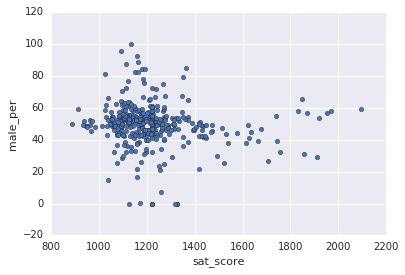

In [19]:
combined.plot.scatter('sat_score','male_per')

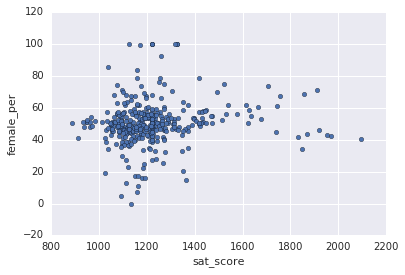

In [20]:
combined.plot.scatter('sat_score','female_per')

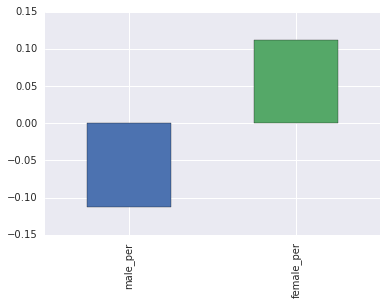

In [21]:
correlations[['male_per','female_per']].plot.bar()

very weak relation

In [22]:
def plot_null_corr(df):
    # create a correlation matrix only for columns with at least one missing value
    cols_with_nulls = df.columns[df.isnull().sum() > 0]
    missing_corr = df[cols_with_nulls].isnull().corr()
 
    # create a mask to avoid repeated values and make the plot easier to read
    missing_corr = missing_corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(missing_corr), k=1)
 
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(missing_corr, vmin=-1, vmax=1, cbar=False, cmap='RdBu', mask=mask, annot=True)
 
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01  :  text.set_text('')
        else  :  text.set_text(round(t, 2))
        text.set_fontsize('x-large')
 
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')
 
    plt.show()

/dataquest/system/env/python3/lib/python3.4/site-packages/matplotlib/axes/_base.py:3045: UserWarning:

Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0

/dataquest/system/env/python3/lib/python3.4/site-packages/matplotlib/axes/_base.py:2787: UserWarning:

Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0



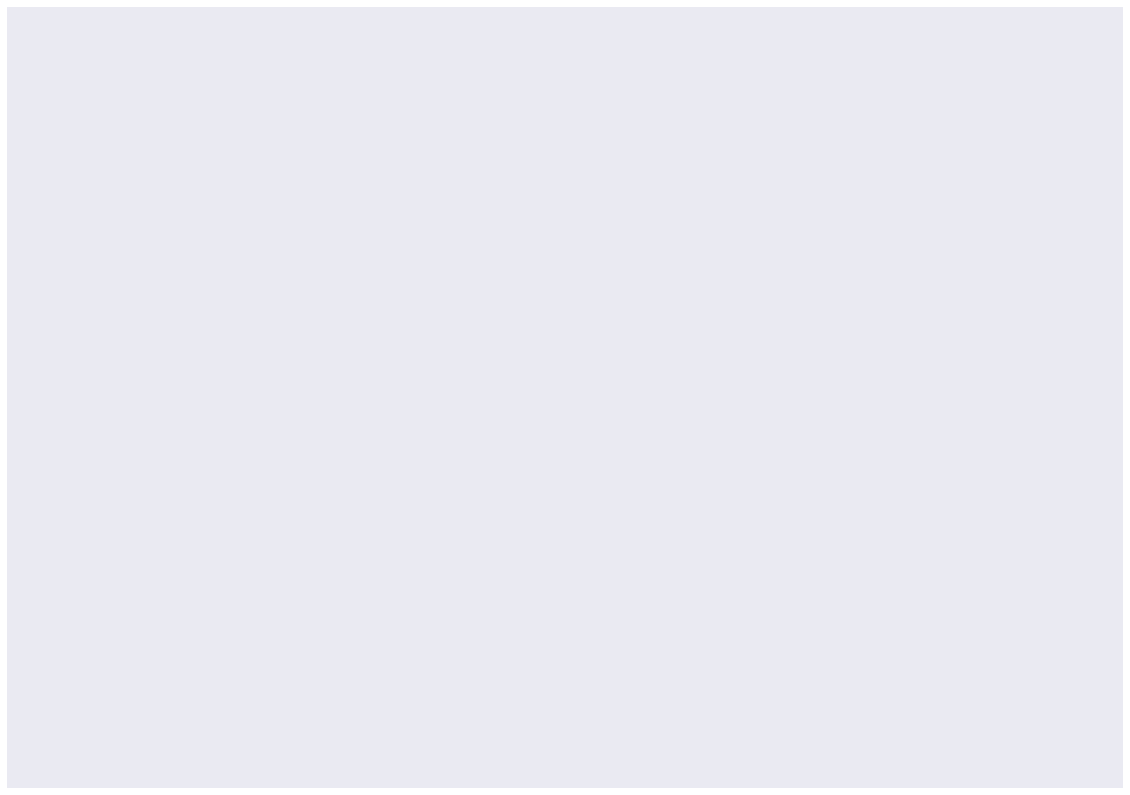

In [23]:
plot_null_corr(combined)

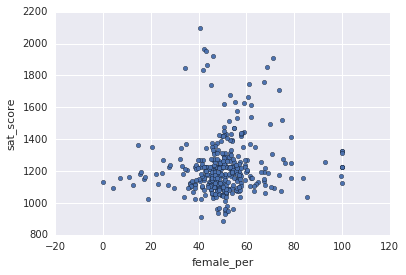

In [24]:
# Investigate schools with high SAT scores and a high female_per.

combined.plot.scatter('female_per', 'sat_score')

In [25]:
combined[(combined['female_per'] > 60) & (combined['sat_score']>1700)]

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,primary_address_line_1,city,state_code,zip,Location 1,start_time,end_time,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,525 East Houston Street,New York,NY,10002,"525 East Houston Street\nNew York, NY 10002\n(...",09:00:00,15:50:00,40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,411 East 76 Street,New York,NY,10021,"411 East 76 Street\nNew York, NY 10021\n(40.77...",08:30:00,15:30:00,40.770116,-73.953379,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,227-243 West 61St Street,New York,NY,10023,"227-243 West 61St Street\nNew York, NY 10023\n...",08:00:00,15:00:00,40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,100 Amsterdam Avenue,New York,NY,10023,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",08:00:00,16:00:00,40.773671,-73.985269,03
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,149-11 Melbourne Avenue,Flushing,NY,11367,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",08:20:00,15:00:00,40.734408,-73.821417,25


In [27]:
# In the U.S., high school students take Advanced Placement (AP)
# exams to earn college credit.
# There are AP exams for many different subjects.
# It makes sense that the number of students at a school who
# took AP exams would be highly correlated with the school's
# SAT scores. Let's explore this relationship.
# Because total_enrollment is highly correlated with sat_score,
# we don't want to bias our results.

# Instead, we'll look at the percentage of students in each
# school who took at least one AP exam.


combined['ap_per']  = combined['AP Test Takers ']/combined['total_enrollment']

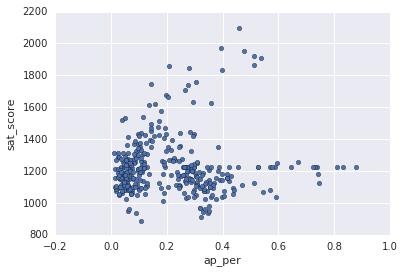

In [29]:
combined.plot.scatter('ap_per','sat_score') 

Here are some potential next steps:

    Determing wheter there's a correlation between class size and SAT scores
    Figuring out which neighborhoods have the best schools
        If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
    Investigating the differences between parent, teacher, and student responses to surveys.
    Assigning scores to schools based on sat_score and other attributes.
